# Generative Adversarial Network (GAN) para generar imágenes de prendas y accesorios

En este cuaderno se implementa una GAN para generar imágenes de prendas y accesorios utilizando el dataset **Fashion MNIST**.

La arquitectura consta de dos modelos:
- **Generador:** Toma un vector de ruido y genera una imagen (28x28 píxeles, escala de grises).
- **Discriminador:** Evalúa imágenes y decide si son reales (del dataset) o generadas (falsas).

El entrenamiento se realiza en forma adversarial, donde el generador mejora al "engañar" al discriminador, y éste se vuelve mejor distinguiendo imágenes reales de las generadas.

**Versión:** Tensorflow.

## Paso 1: Importación de librerías y configuración
Aquí se importan las librerías necesarias y se configura el entorno (por ejemplo, para reproducibilidad).

In [1]:
# Importar las librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

# Configurar la semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)
LATEM_DIM = 100

print("Librerías importadas y configuración inicial completada.")

Librerías importadas y configuración inicial completada.


## Paso 2: Carga y preprocesamiento del dataset Fashion MNIST
Esta celda se encarga de cargar el dataset, normalizarlo y darle la forma adecuada para el entrenamiento.

In [2]:
# Cargar el dataset Fashion MNIST
(x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar las imágenes a un rango [-1, 1] (esto es importante para la activación tanh del generador)
x_train = (x_train - 127.5) / 127.5

# Agregar un canal para que la forma sea (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)

# Mezclar el dataset
permutation = np.random.permutation(x_train.shape[0])
x_train = x_train[permutation]

# Convertir x_train en un tf.data.Dataset y organizarlo en batches
BATCH_SIZE = 32  # Puedes ajustar el tamaño del batch según tus necesidades
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=x_train.shape[0]).batch(BATCH_SIZE)

print("Dataset cargado, preprocesado y organizado en batches:", x_train.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Dataset cargado, preprocesado y organizado en batches: (60000, 28, 28, 1)


## Paso 3: Definición del modelo Generador
Aquí se define el modelo del generador. Este modelo recibe un vector de ruido y produce una imagen de 28x28x1.

In [3]:
# Define el generador
LATENT_DIM = 100

generator = keras.Sequential([
    # Capa densa y normalización para formar un mapa de características 7x7x256
    layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Redimensiona a 7x7x256
    layers.Reshape((7, 7, 256)),

    # Primera capa de convolución transpuesta: 7x7 -> 14x14
    layers.Conv2DTranspose(128, kernel_size=5, strides=1, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución transpuesta: 14x14 -> 28x28
    layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Capa final: ajusta a 28x28 con 1 canal y activa con tanh (para valores en [-1,1])
    layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', use_bias=False, activation='tanh')
])

generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

Ahora comprobamos que el generador funcione correctamente y sin errores en el proceso... e imprimimos dicha imagen generada.

Dimensiones de la imagen generada: (1, 28, 28, 1)
Rango de valores de la imagen generada: de -0.05754662 a 0.06445051


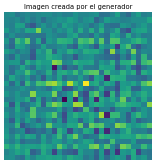

In [4]:
# Comprueba que el generador está funcionando correctamente

# Genera un vector latente aleatorio (ruido)
noise = tf.random.normal([1, LATENT_DIM])

# Genera una imagen utilizando el generador
generated_image = generator(noise, training=False)

# Muestra las dimensiones de la imagen generada
print("Dimensiones de la imagen generada:", generated_image.shape)

# Verifica el rango de valores de la imagen generada
print("Rango de valores de la imagen generada: de", generated_image.numpy().min(), "a", generated_image.numpy().max())

# Muestra la imagen generada
plt.figure(dpi=40)
plt.imshow((generated_image[0] + 1) / 2) # Reescala la imagen al rango [0, 1] para visualizarla
plt.axis("off")
plt.title("Imagen creada por el generador")
plt.show()

## Paso 4: Definición del modelo Discriminador
Esta celda define el modelo del discriminador, que toma una imagen y devuelve una probabilidad (entre 0 y 1) indicando si la imagen es real o generada.

In [5]:
# Define el discriminador
discriminator = keras.Sequential([
    # La forma de entrada se actualiza a 28x28x1
    layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(28, 28, 1)),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, strides=2, padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')  # Salida entre 0 y 1
])

discriminator.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Y ahora ponemos a prueba el discriminador que acabamos de definir:

In [6]:
# Prueba el discriminador con una imagen creada por el generador

noise = tf.random.normal([1, LATEM_DIM])
generated_image = generator(noise, training=False)

# Pasa la imagen por el discriminador
decision = discriminator(generated_image)
print("Decisión del discriminador (valor cercano a 0 = falsa, 1 = real):", decision.numpy())

Decisión del discriminador (valor cercano a 0 = falsa, 1 = real): [[0.50046253]]


## Paso 6: Función de entrenamiento y definición de parámetros
Ahora se definen los parámetros de entrenamiento y la función de entrenamiento que realizará el ciclo adversarial. Se incluye la generación de imágenes de muestra durante el entrenamiento.

In [7]:
# Parámetros del entrenamiento
EPOCHS = 100
# LATENT_DIM = 100
# BATCH_SIZE = 32

In [8]:
# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)  # No se necesita logits porque la última capa era una sigmoide
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [9]:
# Parámetros del entrenamiento
EPOCHS = 100
BATCH_SIZE = 32  # Asegúrate de definir un tamaño de lote
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

# Inicializa los optimizadores y la función de pérdida
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

print("Inicio del entrenamiento de la GAN...\n")

for epoch in range(EPOCHS):
    # Variables para acumular la pérdida en la época
    total_disc_loss = 0.0
    total_gen_loss = 0.0
    batch_count = 0

    # Itera por cada lote en el dataset
    for real_images in dataset:
        batch_count += 1
        current_batch_size = real_images.shape[0]

        # --- Entrenamiento del discriminador ---
        noise = tf.random.normal([current_batch_size, LATENT_DIM])
        generated_images = generator(noise, training=True)
        real_labels = tf.ones((current_batch_size, 1))
        fake_labels = tf.zeros((current_batch_size, 1))

        with tf.GradientTape() as disc_tape:
            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(generated_images, training=True)
            disc_loss_real = cross_entropy(real_labels, real_output)
            disc_loss_fake = cross_entropy(fake_labels, fake_output)
            disc_loss = disc_loss_real + disc_loss_fake

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        # --- Entrenamiento del generador ---
        noise = tf.random.normal([current_batch_size, LATENT_DIM])
        with tf.GradientTape() as gen_tape:
            generated_images = generator(noise, training=True)
            fake_output = discriminator(generated_images, training=False)
            gen_loss = cross_entropy(real_labels, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        total_disc_loss += disc_loss.numpy()
        total_gen_loss += gen_loss.numpy()

    # Calcula las pérdidas promedio para la época
    avg_disc_loss = total_disc_loss / batch_count
    avg_gen_loss = total_gen_loss / batch_count

    # Muestra las pérdidas promedio de la época
    print(f"Época {epoch+1}/{EPOCHS} - Pérdida Discriminador: {avg_disc_loss:.4f}, Pérdida Generador: {avg_gen_loss:.4f}")

    # Cada 5 épocas, guarda los modelos en formato .keras y genera/salva una imagen 3x3 de ejemplo
    if (epoch + 1) % 5 == 0:
        generator.save(f"fashion_mnist_generador_epoch{epoch+1}.keras")
        discriminator.save(f"fashion_mnist_discriminador_epoch{epoch+1}.keras")

        noise = tf.random.normal([9, LATENT_DIM])
        generated_images = generator(noise, training=False)
        # Reescala las imágenes de [-1, 1] a [0, 1]
        generated_images = (generated_images + 1) / 2

        # Configura la cuadrícula 3x3
        fig, axes = plt.subplots(3, 3, figsize=(6, 6))
        for idx, ax in enumerate(axes.flat):
            # Para imágenes en escala de grises, se usa cmap="gray" y se extrae el canal único
            ax.imshow(generated_images[idx, :, :, 0], cmap="gray")
            ax.axis("off")
        plt.tight_layout()
        plt.savefig(f"img_train_epoch{epoch+1}.png")
        plt.close(fig)

Inicio del entrenamiento de la GAN...



KeyboardInterrupt: 